## 1. Requirement

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from art.attacks import FastGradientMethod
from art.attacks import DeepFool
from art.attacks import SaliencyMapMethod
from art.attacks import ProjectedGradientDescent
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

## 2. Model

In [2]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # mnist의 경우 28*28의 흑백이미지(input channel=1)이다.
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, padding=2)
        # feature map의 크기는 14*14가 된다
        # 첫번재 convolution layer에서 나온 output channel이 32이므로 2번째 input도 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, padding=2)
        # feature map의 크기는 7*7이 된다
        # fc -> fully connected, fc는 모든 weight를 고려해서 만들기 때문에 cnn에서는 locally connected를 이용하여 만든다.
        # nn.Linear에서는 conv를 거친 feature map을 1차원으로 전부 바꿔서 input을 한다. 이게 64*7*7
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7) # linear에 들어갈 수 있도록 reshape
        x = F.relu(self.fc1(x)) # fully connected에 relu 적용
        x = F.dropout(x, training=self.training) # 가중치 감소만으로는 overfit을 해결하기가 어려움, 그래서 뉴런의 연결을 임의로 삭제
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## 3. Load MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

## 4. Load the models

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
if is_cuda: print("CUDA available!")

CUDA available!


In [5]:
models = []

model_path = './model/mnist_um_art.pth'
model = MnistModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
models.append(model)

model_path = './model/mnist_um_art.pth'
model = MnistModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
models.append(model)

print("2 clean models loaded")

2 clean models loaded


## 5. Create the ART classifier

In [6]:
criterion = nn.CrossEntropyLoss()

# 0-um, 1-trained
classifiers = []
for model in models:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    classifier = PyTorchClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), loss=criterion,
                               optimizer=optimizer, input_shape=(1, 28, 28), nb_classes=10)
    classifiers.append(classifier)

print("classifiers created")

classifiers created


## 6. Generate adversarial test and train examples

In [7]:
adv_tests = []
adv_trains = []
trained = classifiers[1]


Linf1_attack = FastGradientMethod(classifier=trained, eps=0.3)

Linf1_x_test_adv = Linf1_attack.generate(x=x_test)
adv_tests.append(Linf1_x_test_adv)

Linf1_x_train_adv = Linf1_attack.generate(x=x_train)
adv_trains.append(Linf1_x_train_adv)

print('FGSM example generated')

FGSM example generated


In [8]:
Linf2_attack = ProjectedGradientDescent(classifier=trained, eps=0.3)

Linf2_x_test_adv = Linf2_attack.generate(x=x_test)
adv_tests.append(Linf2_x_test_adv)

Linf2_x_train_adv = Linf2_attack.generate(x=x_train)
adv_trains.append(Linf2_x_train_adv)

print('PGD example generated')

PGD example generated


In [9]:
L0_attack = SaliencyMapMethod(classifier=trained)

L0_x_test_adv = L0_attack.generate(x=x_test)
adv_tests.append(L0_x_test_adv)

L0_x_train_adv = L0_attack.generate(x=x_train)
adv_trains.append(L0_x_train_adv)

print('JSMA example generated')

JSMA example generated


In [10]:
L2_attack = DeepFool(classifier=trained)

L2_x_test_adv = L2_attack.generate(x=x_test)
adv_tests.append(L2_x_test_adv)

L2_x_train_adv = L2_attack.generate(x=x_train)
adv_trains.append(L2_x_train_adv)

print('Deepfool example generated')

Deepfool example generated


## 7. Train model

In [12]:
print("Training with adversarial example...\n")

for i, (x_train_adv) in enumerate(adv_trains):
    classifiers[1].fit(x_train_adv, y_train, batch_size=64, nb_epochs=30)
    print('Train {} done'.format(i))

Training with adversarial example...

Train 0 done
Train 1 done
Train 2 done
Train 3 done


## 8. Evaluate model on adversarial examples

In [34]:
models_accuracy = []
examples = []

print('model #: 0-um, 1-trained')
print('test #: 0-fgsm, 1-pgd, 2-jsma, 3-deepfool')

# test order: 0-fgsm, 1-pgd, 2-jsma, 3-deepfool
for i, (classifier) in enumerate(classifiers):
    print('\nmodel #{}'.format(i))
    model_accuracy = []
    example = []
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print('Accuracy on benign test examples: {}%'.format(accuracy * 100)) 
    model_accuracy.append(accuracy)
    b_ex = []
    for idx, (pred) in enumerate(predictions):
        if np.argmax(pred) != np.argmax(y_test[idx]):
            b_ex.append((x_test[idx], np.argmax(pred), np.argmax(y_test[idx])))
        if len(b_ex) == 5: 
            example.append(b_ex)
            break
        
    for j, (x_test_adv) in enumerate(adv_tests):
        adv_ex = []
        predictions = classifier.predict(x_test_adv)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        print('Accuracy on model with adversarial test #{} examples: {}%'.format(j, accuracy * 100))
        model_accuracy.append(accuracy)
        for idx, (pred) in enumerate(predictions):
            if np.argmax(pred) != np.argmax(y_test[idx]):
                adv_ex.append((x_test_adv[idx], np.argmax(pred), np.argmax(y_test[idx])))
            if len(adv_ex) == 5: 
                example.append(adv_ex)
                break
    models_accuracy.append(model_accuracy)
    examples.append(example)

model #: 0-um, 1-trained
test #: 0-fgsm, 1-pgd, 2-jsma, 3-deepfool

model #0
Accuracy on benign test examples: 99.16%
Accuracy on model with adversarial test #0 examples: 2.7199999999999998%
Accuracy on model with adversarial test #1 examples: 0.76%
Accuracy on model with adversarial test #2 examples: 56.279999999999994%
Accuracy on model with adversarial test #3 examples: 40.93%

model #1
Accuracy on benign test examples: 98.77%
Accuracy on model with adversarial test #0 examples: 95.7%
Accuracy on model with adversarial test #1 examples: 95.61%
Accuracy on model with adversarial test #2 examples: 82.78999999999999%
Accuracy on model with adversarial test #3 examples: 98.97%


## 9. Result

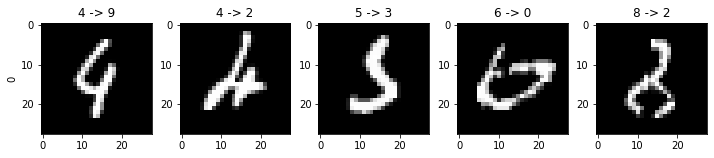

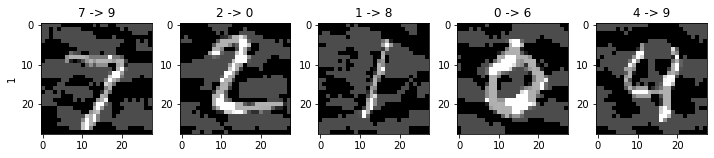

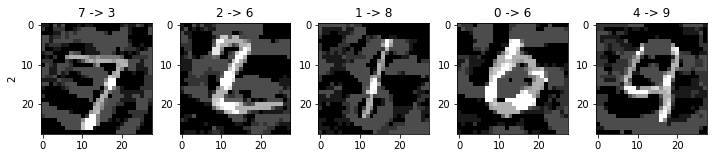

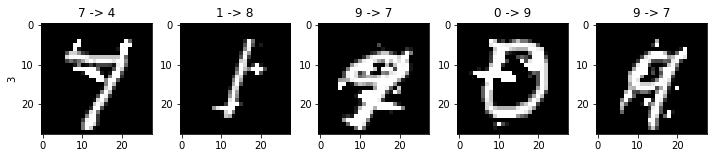

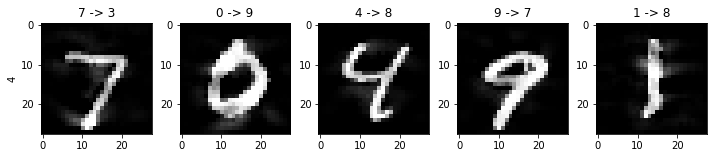

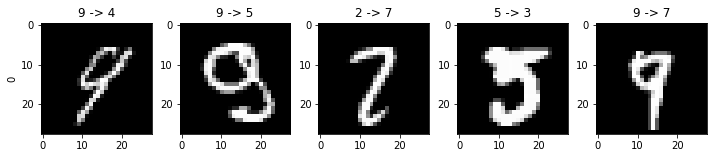

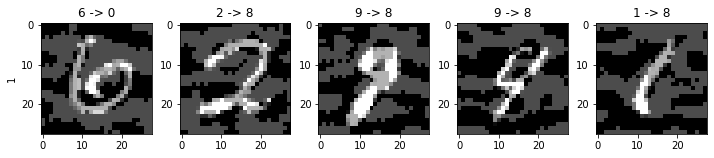

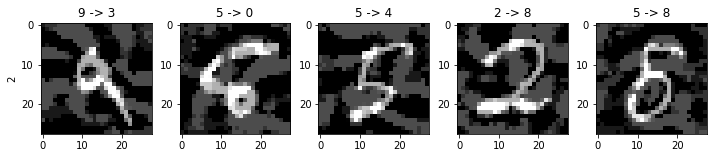

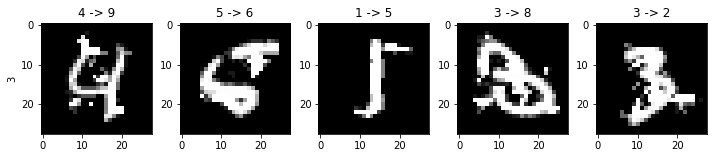

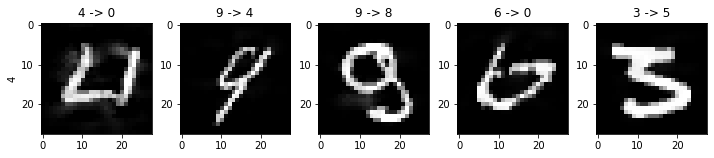

In [44]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
%matplotlib inline

SAVE_PATH = './examples/07/'


for i, (example) in enumerate(examples):
    for j, (images) in enumerate(example):    
        plt.figure(figsize=(10,10))
        cnt = 0
        for k, (image, pred, orig) in enumerate(images):
            cnt+=1
            plt.subplot(5, len(images), cnt)
            if k == 0:
                plt.ylabel(str(j))
            plt.title('{} -> {}'.format(orig, pred))
            plt.imshow(np.rot90(np.flip(image.reshape(28, 28, order='C'), axis=1)), cmap='gray')
            title = SAVE_PATH + str(i) +'_'+ str(j) + '_[' + str(orig) + '_' + str(pred) +'].png'
            save_image(torch.from_numpy(np.rot90(np.flip(image.reshape(28, 28, order='C'), axis=1))), title)
        plt.tight_layout()
        plt.show()    

In [45]:
import pandas as pd
from pandas import DataFrame

data = {
    'clean': models_accuracy[0],
    'trained': models_accuracy[1],
}

columns = ['clean', 'trained']
idx = ['Benign' ,'FGSM', 'PGD', 'JSMA', 'Deepfool']
DataFrame(data, columns=columns, index=idx)

,clean,trained
Benign,0.9916,0.9877
FGSM,0.0272,0.9570
PGD,0.0076,0.9561
JSMA,0.5628,0.8279
Deepfool,0.4093,0.9897


## 10. Save trained model

In [16]:
model_save = models[1]
PATH = './model/mnist_all_art.pth'
torch.save(model_save.state_dict(), PATH)